<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/SARS_CoV_2_Analysis_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>SARS-Cov-2 Analysis Workflow</h1>

This tutorial implements the best-practices bioinformatics workflow for the assembly of an SARS-CoV-2 viral genomes. The workflow in the document implements the [ARTIC Nanopore bioinformatics SOP](https://https://artic.network/ncov-2019/ncov2019-bioinformatics-sop.html).

Computational requirements for this tutorial include:

- Computer running the **EPI2ME Labs** notebook Server
- At least 16 Gb RAM
- An internet connection

> ⚠️ **Warning:** Before starting a new analysis it is recommeded to select `Edit > Clear all outputs` from the menu above before using the notebook.



## Getting Started



⚠️ ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See Run a tutorial on the EPI2ME Labs Server help page for more information.

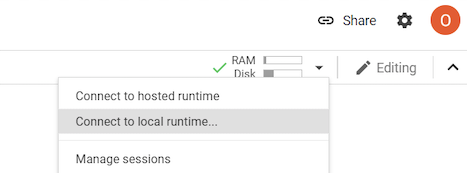

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [1]:
from epi2melabs import ping
tutorial_name = 'ncov_tutorial'
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/ncov_tutorial


### Install additional software

The default **EPI2MELabs** environment does not contain the ARTIC software. In this section we will prepare the enviroment with the necessary ARTIC software installation.

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server*

Having connected to the EPI2ME Labs Server, we will install the necessary software. Press the play button below to the left hand side (it may appear as `[ ]`):

In [ ]:
#@markdown **ARTIC Bioinformatics installation** *(click the play button to install)*
import os
%cd "$working_dir"
if os.path.exists("artic-ncov2019"):
    print("Found existing install, removing.")
    !rm -rf artic-ncov2019
print("Downloading artic-ncov")
# we need this just for primerset data
!git clone https://github.com/artic-network/artic-ncov2019.git

# install artic analysis pipeline
if os.path.exists("fieldbioinformatics"):
    print("Found existing install, removing.")
    !rm -rf fieldbioinformatics
!git clone https://github.com/artic-network/fieldbioinformatics
%cd fieldbioinformatics
!conda env remove -n artic
!conda env create -f environment.yml
!source /opt/conda/etc/profile.d/conda.sh \
    && conda activate artic \
    && pip install . && pip install ipykernel
!echo "\nTesting install"
!run artic --version

%cd "$working_dir"

### Sample Data

This tutorial is provided with a sample dataset. This dataset contains a range of multiplexed samples, some from real clinical samples others and synthetic control preparations.

To download the sample file we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

!wget -O sample_ncov.tar.gz "$site/ncov_tutorial/sample_ncov.tar.gz"
print("Extracting data...")
!rm -rf sample_ncov
!tar -xzf sample_ncov.tar.gz
print("Done.")

### Using your own data

If you have your own sequencing, you can edit the value of the input variables below in the **Data Entry** section. To find the correct full path of a file you can navigate to it in the **Files** browser to the left-hand side, right-click on the file and select **Copy path**:

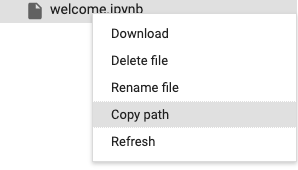

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data Entry

The workflow requires `.fastq` files from an Oxford Nanopore Technologies' sequencing device. These should not have previously been trimmed of barcodes as this will be performed as part of the workflow.


The input folder should be the top level MinKNOW (or Guppy) output folder containing the `fastq_pass` folder and `sequencing_summary.txt` file.

In [34]:
#@markdown **Analysis Parameters** *(fill in the required values and then press play)*
import glob
import os
import shutil

import aplanat.report
from epi2melabs import notebook

debug = True
ref_name = "MN908947.3"
ref_len = 29903

input_folder = "/epi2melabs/ncov_tutorial/sample_ncov" #@param {type:"string"}
output_folder = "/epi2melabs/ncov_tutorial/analysis/" #@param {type:"string"}
run_name = "run0" #@param {type:"string"}
overwrite = True #@param {type:"boolean"}
threads =  64#@param {type:"integer"}
primer_set = "nCoV-2019/V3" #@param ["nCoV-2019/V1", "nCoV-2019/V2", "nCoV-2019/V3"]
minimum_reads = 30000 #@param {type:"integer"}
min_read_length = 400 #@param {type:"integer"}
max_read_length = 700 #@param {type:"integer"}
barcode_arrangements = "barcode_arrs_nb12.cfg barcode_arrs_nb24.cfg" #@param {type:"string"}

success = True
msg_lines = []

# check input folder
if not os.path.exists(input_folder):
    msg = "`{}` does not exist.".format(input_folder)
    success = False
else:
    msg = input_folder
msg_lines.append("Input folder:  {}".format(msg))

# check fastq_pass folder
fastq_pass = os.path.join(input_folder, 'fastq_pass')
if not os.path.exists(fastq_pass):
    msg = notebook.error("fastq_pass folder not found under {}.".format(input_folder))
    success = False
else:
    msg = fastq_pass
msg_lines.append("fastq folder:  {}".format(msg))

# check summary file
seqsum_glob = "sequencing_summary_*_*.txt"
seqsums = glob.glob(os.path.join(input_folder, seqsum_glob))
if len(seqsums) == 0:
    msg = notebook.error("No file matching {} under {}.".format(seqsum_glob, input_folder))
    success = False
else:
    seq_summary_file = seqsums[0]
    msg = seq_summary_file
msg_lines.append("seq. summary:  {}".format(msg))

# check output
if os.path.exists(output_folder) and not overwrite:
    msg = notebook.error("{} exists, overwrite not selected".format(output_folder))
    success = False
else:
    if os.path.exists(output_folder):
        print("- Previous output folder exists, removing")
        try:
            shutil.rmtree(output_folder)
        except:
            print(notebook.error('- Error while deleting directory'))
    os.mkdir(output_folder)
    msg = output_folder
msg_lines.append("Output folder: {}".format(msg))

print()
print("Configuration")
print("-------------")
for line in msg_lines:
    print(line)
if success:
    !cecho success "Inputs setup correctly."
else:
    !cecho error "One of more errors occurred finding inputs."

report = aplanat.report.HTMLReport(
    "SARS-Cov-2 Analysis",
    "EPI2MELabs summary report for: {}.".format(run_name),
    require_keys = True)
report.markdown("""
###Analysis Parameters

    input: {}
    primer set: {}
    minimum reads: {}
    min. read length: {}
    max. read length: {}
    barcode arrangements: {}
""".format(
    input_folder, primer_set, minimum_reads, min_read_length, max_read_length,
    barcode_arrangements) , key="simple preamble")



- Previous output folder exists, removing

Configuration
-------------
Input folder:  /epi2melabs/ncov_tutorial/sample_ncov
fastq folder:  /epi2melabs/ncov_tutorial/sample_ncov/fastq_pass
seq. summary:  /epi2melabs/ncov_tutorial/sample_ncov/sequencing_summary_FAL50547_8e49b54f.txt
Output folder: /epi2melabs/ncov_tutorial/analysis/
Inputs setup correctly.


## Analysis

With our software environment set up and our inputs specified it is time to move on the the analysis. The following workflow begins with demultiplexing the reads using strict settings to avoid misidentification, followed by running of the Artic analysis, and finally creation of Quality control plots to determine if tha analysis is valid.

### Demultiplexing and Read Quality Control

In this section we will run sample demultiplexing using the `guppy_barcoder` software. The results of this will appear in the output folder under the `demultiplex` folder. After demultiplexing a report is produced by merging results of the demultiplexing with the "sequencing summary" file from the original MinKNOW output.

Use the code cell below to run the demultiplexing:

In [36]:
#@markdown **Running Guppy demultiplexing** *(press play)*
!rm -rf $output_folder/demultiplex
!guppy_barcoder \
    --require_barcodes_both_ends --arrangements_files "$barcode_arrangements" \
    --compress_fastq --records_per_fastq 0 --recursive --worker_threads $threads \
    --save_path $output_folder/demultiplex \
    --input_path $input_folder \
    && cecho success "Guppy finished successfully" \
    || cecho error "Guppy failed"


ONT Guppy barcoding software version 3.5.2+5b7a51b
input path:         /epi2melabs/ncov_tutorial/sample_ncov
save path:          /epi2melabs/ncov_tutorial/analysis//demultiplex
arrangement files:  barcode_arrs_nb12.cfg barcode_arrs_nb24.cfg
min. score front:   60
min. score rear:    60


Found 371 fastq files.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Done in 151201 ms.
Guppy finished successfully


The demultiplexing produces a summary file recording the barcode found in each read, or "unclassified" if the barcodes could not be confidently identified.

In [37]:
#@markdown **Merging data files** *(press play)*
import pandas as pd

success = False
bc_summary, seq_summary = None, None
barcode_summary_file = os.path.join(output_folder, "demultiplex", "barcoding_summary.txt")
if not os.path.exists(barcode_summary_file):
    !cecho error "Could not find barcode summary: $barcode_summary_file"
else:
    print("Reading demultiplex summary: {}.".format(barcode_summary_file))
    try:
        bc_summary = pd.read_csv(barcode_summary_file, sep='\t')
    except Exception as e:
        !cecho error "Could not read barcode summary: $barcode_summary"
        if debug:
            raise e

print("Reading sequencing summary: {}".format(seq_summary_file))
try:
    seq_summary = pd.read_csv(seq_summary_file, sep='\t')
except Exception as e:
    !cecho error "Could not read barcode summary: $seq_summary_file"
    if debug:
        raise e

if not any(x is None for x in (bc_summary, seq_summary)):
    print("Merging barcode and sequencing summaries.")
    to_drop = [x for x in seq_summary.columns if x.startswith('barcode')]
    seq_summary = seq_summary.drop(columns=to_drop)
    try:
        summary = pd.merge(bc_summary, seq_summary, on='read_id')
    except Exception as e:
        !cecho error "Could not merge files."
        if debug:
            print(e)
    else:
        success = True
if success:
    !cecho success "Sequencing and barcode summaries read and merged."
else:
    !cecho error "One or more errors occurred reading input files."

Reading demultiplex summary: /epi2melabs/ncov_tutorial/analysis/demultiplex/barcoding_summary.txt.
Reading sequencing summary: /epi2melabs/ncov_tutorial/sample_ncov/sequencing_summary_FAL50547_8e49b54f.txt
Merging barcode and sequencing summaries.
Sequencing and barcode summaries read and merged.


To generate a QC report, run the cell below:



In [38]:
#@markdown **Reads QC Report** *(press play)*
import aplanat
from aplanat import bars, hist, annot
from bokeh.models import Span
from bokeh.layouts import gridplot
import numpy as np

plots = list()

total_bases = seq_summary['sequence_length_template'].sum()
mean_length = total_bases / len(seq_summary)
median_length = np.median(seq_summary['sequence_length_template'])

# read length plot
datas = [summary['sequence_length_template']]
length_hist = hist.histogram(
    datas, bins=400,
    title="Read length distribution.",
    x_axis_label='Read Length / bases',
    y_axis_label='Number of reads',
    xlim=(0, 2000))
length_hist = annot.subtitle(
    length_hist,
    "Mean: {:.0f}. Median: {:.0f}".format(
        mean_length, median_length))
plots.append(length_hist)

# barcode count plot
barcode_counts = pd.DataFrame(summary['barcode_arrangement'].value_counts()) \
    .sort_index().reset_index().rename(
        columns={'index':'barcode', 'barcode_arrangement':'count'})
bc_counts = bars.simple_bar(
    barcode_counts['barcode'], barcode_counts['count'],
    title='Number of reads per barcode')
bc_counts = annot.subtitle(
    bc_counts,
    'Barcodes with fewer than {} reads will not be analysed further.'.format(
        minimum_reads))
bc_counts.xaxis.major_label_orientation = 3.14/2
bc_counts = annot.marker_hline(bc_counts, minimum_reads)
plots.append(bc_counts)

# determine which barcode datasets are good
barcode_counts['sufficient data'] = barcode_counts['count'] > minimum_reads
valid_barcodes = set(
    barcode_counts.loc[barcode_counts['sufficient data']]['barcode'])

plots = gridplot(plots, ncols=2)
aplanat.show(plots)
report.markdown("""
### Read Quality Control

The following depicts reads remaining after barcode demultiplexing.
""", key="qc_header")
report.plot(plots, key="qc_plots")

### Run ARTIC for each sample

With demultiplexed reads, we are in a position to analyse each dataset independently using the ARTIC workflow.

In [39]:
#@markdown **Run ARTIC analysis for each barcode** *(press play)*
def run_artic(
        barcode, directory, artic_output,
        min_len=400, max_len=700, run_name="run0", threads=8,
        scheme="V3"):
    !mkdir -p $artic_output/$barcode
    prefix = os.path.join(artic_output, barcode, run_name)
    log_file = "{}_artic.log".format(prefix)
    read_file = "{}_{}.fastq".format(prefix, barcode)
    print("Writing log file to: {}.".format(log_file))
    # read filtering
    !cecho ok "Running artic guppyplex to filter reads"
    # note, artic commands seem to exit 0 even if they fail,
    # so our && || below don't function as intended
    !run artic guppyplex --skip-quality-check \
        --min-length $min_len --max-length $max_len \
        --directory $directory --prefix $prefix >>$log_file 2>&1 \
        && echo " - artic guppyplex finished"
    #    && cecho success "artic guppyplex run successfully" \
    #    || cecho error "artic guppyplex failed"
    # run everything else
    !cecho ok "Running artic minion --medaka to call variants"
    !run artic minion --medaka --normalise 200 --threads $threads \
        --scheme-directory $working_dir/artic-ncov2019/primer_schemes \
        --read-file $read_file $scheme \
        $prefix >>$log_file 2>&1 \
        && echo " - artic minion finished"
    #    && cecho success "artic minion run successfully" \
    #    || cecho error "artic minion failed"
    !cecho ok "Running alignment QC"
    for i in (1,2):
        bam = "{}.primertrimmed.nCoV-2019_{}.sorted.bam".format(prefix, i)
        if os.path.isfile(bam):
            !stats_from_bam $bam > $bam".stats"
            !coverage_from_bam -s 50 -p $bam $bam
        else:
            !echo error " - No Artic output bam file found for primer set $i, Artic failed."
    return prefix

# setup artic output
artic_output = os.path.join(output_folder, "artic")

# run analysis for each barcode
valid_barcodes = [
    x for x in barcode_counts.loc[barcode_counts['sufficient data']]['barcode']
    if x != "unclassified"]
print(notebook.warning("Running Artic for:"))
for barcode in valid_barcodes:
    print("   {}".format(barcode))
print()
for barcode in valid_barcodes:
    msg = "Running ARTIC analysis for: {}".format(barcode)
    print(notebook.warning(msg))
    print(notebook.warning("-" * len(msg)))
    print()
    artic_input = os.path.join(output_folder, "demultiplex", barcode)
    !rm -rf $artic_output/$barcode
    out_prefix = run_artic(
        barcode, artic_input, artic_output,
        min_len=min_read_length, max_len=max_read_length, run_name=run_name, 
        threads=threads, scheme=primer_set)
    print("Results for {} can be found at {}".format(barcode, out_prefix))
    msg = "ARTIC finished for: {}".format(barcode)
    print(msg)
    print("=" * len(msg))
    print()

Running Artic for:
   barcode01
   barcode02
   barcode03
   barcode05

Running ARTIC analysis for: barcode01
-------------------------------------

Writing log file to: /epi2melabs/ncov_tutorial/analysis/artic/barcode01/run0_artic.log.
Running artic guppyplex to filter reads
 - artic guppyplex finished
Running artic minion --medaka to call variants
 - artic minion finished
Running alignment QC
Mapped/Unmapped/Short/Masked: 14312/0/0/0
[17:20:43 - root] Processing region MN908947.3:0-29900
Mapped/Unmapped/Short/Masked: 13711/0/0/0
[17:20:45 - root] Processing region MN908947.3:0-29900
Results for barcode01 can be found at /epi2melabs/ncov_tutorial/analysis/artic/barcode01/run0
ARTIC finished for: barcode01

Running ARTIC analysis for: barcode02
-------------------------------------

Writing log file to: /epi2melabs/ncov_tutorial/analysis/artic/barcode02/run0_artic.log.
Running artic guppyplex to filter reads
 - artic guppyplex finished
Running artic minion --medaka to call variants
 - 

The ARTIC worflow produces the following files for each barcode (*\<run_name>* is the value given at the top of this page):

1. `<run_name>.rg.primertrimmed.bam` - BAM file for visualisation after primer-binding site trimming
2. `<run_name>.trimmed.bam` - BAM file with the primers left on (used in variant calling)
3. `<run_name>.merged.vcf` - all detected variants in VCF format
4. `<run_name>.pass.vcf.gz` - detected variants in VCF format passing quality filter
5. `<run_name>.fail.vcf` - detected variants in VCF format failing quality filter
6. `<run_name>.primers.vcf` - detected variants falling in primer-binding regions
7. `<run_name>.consensus.fasta` - consensus sequence

These will be present in folders named as:

    <output_folder>/analysis/artic/<barcode>/

where `<output_folder>` is the value given at the top of this page and `<barcode>` is the identified barcode for each dataset.

#### Brief summary of results

Running the below will produce a simple tabular summary for each barcoded dataset.

In [45]:
#@markdown **ARTIC Summary Table** *(click play)*
from collections import Counter, defaultdict
import gzip
from pysam import FastxFile
from Bio import SeqIO

!cecho ok "The tables below assume you are using up to 24 barcodes."

results = defaultdict(dict)
for barcode in ('barcode{:02}'.format(x) for x in range(1,25)):
    results[barcode]["Ns"] = 'NA'
    results[barcode]['variants'] = 'NA'
    if not barcode in valid_barcodes:
        continue
    consensus_file = os.path.join(
        artic_output, barcode, "{}.consensus.fasta".format(run_name))
    vcf_file = os.path.join(
        artic_output, barcode, "{}.pass.vcf.gz".format(run_name))
    recs = 0
    try:
        for record in SeqIO.parse(consensus_file, "fasta"):
            recs += 1
            results[barcode]["Ns"] = record.seq.count("N")
    except FileNotFoundError as e:
        !cecho error "ARTIC pipeline failed to produce consensus.fasta file for $barcode"
        continue
    else:
        if recs != 1:
            !cecho error "ARTIC pipeline produced one than one consensus contig for $barcode"
            continue
    variants = 0
    with gzip.open(vcf_file) as vcf:
        for line in (x.decode() for x in vcf):
            if line.startswith('#'):
                continue
            variants += 1
    results[barcode]['variants'] = variants


df = pd.DataFrame.from_dict(results)
df.columns = ['bc{:02}'.format(x) for x in range(1,25)]
part1 = ['bc{:02}'.format(x) for x in range(1,13)]
part2 = ['bc{:02}'.format(x) for x in range(13,25)]
display(df[part1])
display(df[part2])
report.markdown("""
### Results

The variants discovered per barcode were as follows. `NA` indicated the barcode
was not present, or that too few reads were obtained for analysis to be performed.
""", key="results_header")
report.table(df[part1], key="summary_pt1")
report.table(df[part2], key="summary_pt2")
    

The tables below assume you are using up to 24 barcodes.
ARTIC pipeline failed to produce consensus.fasta file for barcode05


,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10,bc11,bc12
Ns,4000,4062,4600,NA,NA,NA,NA,NA,NA,NA,NA,NA
variants,3,4,0,NA,NA,NA,NA,NA,NA,NA,NA,NA


,bc13,bc14,bc15,bc16,bc17,bc18,bc19,bc20,bc21,bc22,bc23,bc24
Ns,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
variants,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### QC Summary of ARTIC pipeline results

The results of the ARTIC pipeline include alignment of the reads to a reference genome. A summary of these alignments is produced by the section below. Things to look for here include even coverage of amplicons and that the negative control sample shows little to no data. For the case of the sample data provided with this tutorial, barcode05 is a negative control sample.

In [46]:
#@markdown **Collate ARTIC alignment statistics** *(press play)*
from aplanat import lines
from aplanat import util

pinger.send_notebook_ping('stop', tutorial_name)

bam_name = ".primertrimmed.nCoV-2019_{}.sorted.bam"
cover_suffix = "_{}_0_{}.depth.txt".format(ref_name, ref_len)
stats_suffix = ".stats"

dfs_cover = list()
dfs_stats = list()
for barcode in valid_barcodes:
    stats_stem = os.path.join(artic_output, barcode, run_name)
    for i in (1,2):
        df = pd.read_csv(stats_stem + bam_name.format(i) + cover_suffix, sep='\t')
        df['primer_set'] = i
        df['barcode'] = barcode
        dfs_cover.append(df)
        df = pd.read_csv(stats_stem + bam_name.format(i) + stats_suffix, sep='\t')
        df['primer_set'] = i
        df['barcode'] = barcode
        dfs_stats.append(df)
cover_summary = pd.concat(dfs_cover)
stats_summary = pd.concat(dfs_stats)
dfs_cover, dfs_stats = None, None

In [47]:
#@markdown **Show coverage histograms** *(press play)*
plots = list()
df = cover_summary
depth_lim = 100
for barcode in valid_barcodes:
    pset = df['primer_set']
    bc = df['barcode'] == barcode
    xs = [df.loc[(pset == i) & bc]['pos'] for i in (1,2)]
    ys = [df.loc[(pset == i) & bc]['depth'] for i in (1,2)]
    
    depth = df[bc].groupby('pos')['depth'].sum()
    depth_thresh = 100*(depth >= depth_lim).sum() / len(depth)

    plot = lines.line(
        xs, ys, colors=['blue', 'red'],
        title="{}: {:.0f}X, {:.1f}% > {}X".format(
            barcode, depth.mean(), depth_thresh, depth_lim),
        height=200, width=400,
        x_axis_label='position', y_axis_label='depth')
    plots.append(plot)
plots = gridplot(plots, ncols=3)
aplanat.show(plots)
report.markdown("#### Genome coverage", key="coverage_header")
report.plot(plots, "coverage_plots")

In [48]:
#@markdown **Show basecall accuracies** *(press play)*
plots = list()
df = stats_summary
for barcode in valid_barcodes:
    pset = df['primer_set']
    bc = df['barcode'] == barcode
    try:
        xs, ys = list(), list()
        for i in (1, 2):
            d = df.loc[(pset == i) & bc]
            if len(d) == 0:
                !cecho warning "Warning: No basecalls for $barcode and primer set $i"
                # aplanat can't currently plot empty data
                x, y = [99.9, 100], [0, 0.0001]
            else:
                x, y = util.kernel_density_estimate(d['acc'])
            xs.append(x)
            ys.append(y)
    except:
        pass
    plot = lines.line(
        list(xs), list(ys), colors=['blue', 'red'],
        title=barcode,
        height=200, width=400,
        x_axis_label='read accuracy', y_axis_label='density')
    plots.append(plot)
plots = gridplot(plots, ncols=3)
aplanat.show(plots)
report.markdown("#### Read accuracy", key="accuracy_header")
report.plot(plots, "accuracy_plots")

### Offline Report

To create a standalone document containing all the results from this notebook enter an output filename and run the code cell below:

In [49]:
report_file = "sars-cov-2-report.html" #@param {type:"string"}

report.write(report_file)

## Summary

In this tutorial we have demonstrated use of the Artic pipeline for analysing SARC-CoV-2 samples. The notebook can be used with any .fastq dataset output by MinKNOW.

The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)